## Import relevant libraries

In [1]:
import os,shutil,glob
import json
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import random
from pathlib import Path
from PIL import Image
# Ignore warnings
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings("ignore")

## Create Dataset

In [3]:
class pavement_data(Dataset):
    def __init__(self, root_dir, csv_path):
        self.root = Path(root_dir)

        self.df = pd.read_csv(os.path.join(root_dir,csv_path))
        self.df = self.df.sample(frac=1)
        self.image_names = [os.path.join(self.root,'train',i) for i in self.df['image_name'].values]
        self.pci_label = list(self.df['pci'].values)

    def __len__(self):
        # returns the length of the dataset
        return len(self.image_names)

    def __getitem__(self, idx):

    #     # preprocess and transformations
    #     # indexes the dataset such that dataset[i] can retrieve the ith sample.
        image = self.image_names[idx]
        # print (image)
        if os.path.isfile(image):
            image_data = io.imread(image)
            # print (image_data)

            label = self.pci_label[idx]

            sample = {'image': image_data, 'image_path':image,'label': label}

            return sample

In [10]:
pavement_dataset = pavement_data('new_data','train.csv')

In [ ]:
for idx, sample in enumerate(pavement_dataset):
    print (sample['image'].shape, sample['label'])

    if idx == 5:
        break

In [11]:
def plot_data(pavement_dataset,cls_thresh,num_samples):
  fig = plt.figure(figsize=(20,20))
  ncols = int(np.floor(num_samples/2))+1
  cnt = 0
  df = pavement_dataset.df
  df['image_names'] = pavement_dataset.image_names
  df = df[df['pci'].between(cls_thresh[0],cls_thresh[1])]
  df = df.sample(frac=1)
  df = df.reset_index()
  
  fig, axs = plt.subplots(2, ncols, figsize=(20, 10))

  for i, sample in df.iterrows():
    plt.tight_layout()
    axs[int(i/ncols), (i%ncols)].set_title('Sample PCI - {}'.format(sample['pci']))
    axs[int(i/ncols), (i%ncols)].imshow(io.imread(sample['image_names']))
    axs[int(i/ncols), (i%ncols)].axis('off')
    if i+1 == ncols*2:
      plt.show()
      break
  plt.show()

<Figure size 2000x2000 with 0 Axes>

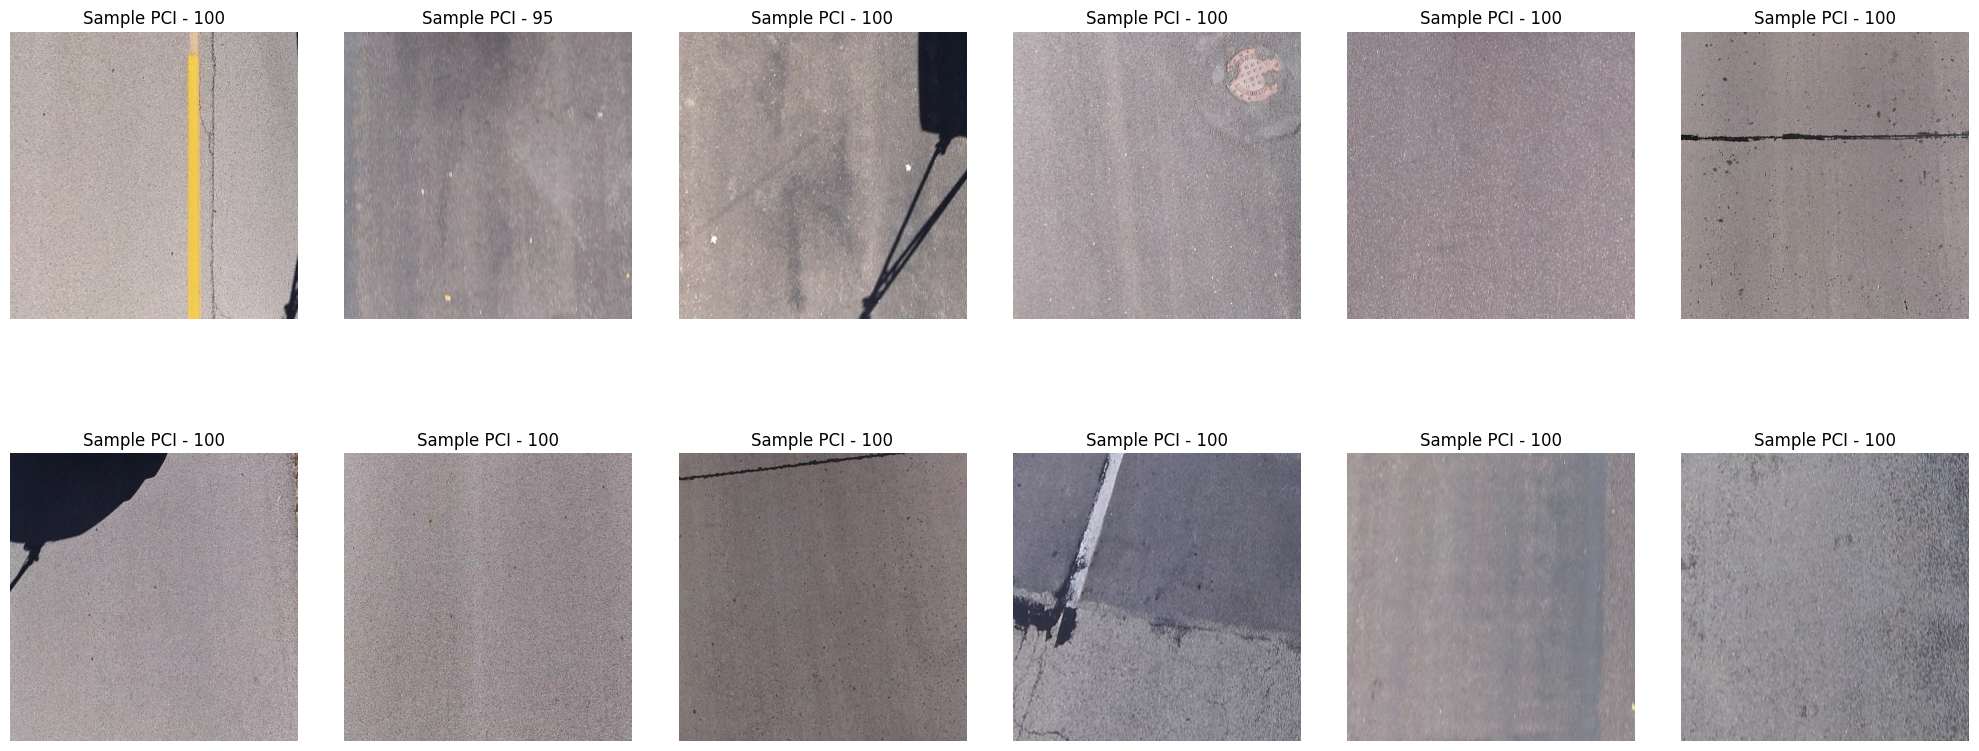

In [9]:
plot_data(pavement_dataset,(90,100),10)

## Prepare the dataset

In [2]:
class prep_data(object):
  def __init__(self,root_dir,csv_path):
    self.root = Path(root_dir)
    self.df = pd.read_csv(os.path.join(root_dir,csv_path))
    self.image_names = [os.path.join(self.root,'train',i) for i in self.df['image_name'].values]
    self.pci_label = list(self.df['pci'].values)
    self.train_folder = os.path.join(root_dir,'yolov8','train')
    self.val_folder = os.path.join(root_dir,'yolov8','val')
    Path(self.train_folder).mkdir(parents=True, exist_ok=True)
    Path(self.val_folder).mkdir(parents=True, exist_ok=True)

  def __call__(self,sample):
    if not sample is None:
      image, img_path, labels = sample['image'],sample['image_path'], sample['label']
      # print (img_path)
      # print (labels)
      dst_folder = os.path.join(self.train_folder,str(labels))
      Path(dst_folder).mkdir(parents=True, exist_ok=True)
      fname = os.path.basename(img_path)
      if not os.path.isfile(os.path.join(dst_folder,fname)):
        shutil.copy2(img_path,dst_folder)

In [13]:
obj_prep = prep_data('new_data','train.csv')

In [14]:
for i, sample in enumerate(tqdm(pavement_dataset)):
    obj_prep(sample)

100%|██████████| 7704/7704 [06:00<00:00, 21.37it/s]


## Move images with negative dir (PCI less than 0) names to 0 directory 

In [16]:
train_dir = '/notebooks/new_data/yolov8/train'
images_dirs = os.listdir(train_dir)

destination_dir = '/notebooks/new_data/yolov8/train/0'

for dirs in images_dirs:
    if int(dirs) < 0:
        all_images_dir = glob.glob(f'{train_dir}/{dirs}/**.jpg')
        for image in all_images_dir:
            shutil.move(image, destination_dir)
            print(f'Copied {image} to PCI-0 directory')

train_dir = '/notebooks/new_data/yolov8/train'
images_dirs = os.listdir(train_dir)

# Delete PCI label folders with negative PCI
for dirs in images_dirs:
    if int(dirs) < 0:
        shutil.rmtree(f'{train_dir}/{dirs}')

Copied /notebooks/new_data/yolov8/train/-7/8536_(40.703158, -89.4063703333333)_ 2023-10-18 18-05-12_21.645_D.jpg to PCI-0 directory
Copied /notebooks/new_data/yolov8/train/-7/1287_[40.699373956663266, -89.40239271668378]_ 2023-10-20 21-38-40_18.9699_LD.jpg to PCI-0 directory
Copied /notebooks/new_data/yolov8/train/-7/19879_[40.707384857570744, -89.43709896672159]_ 2023-10-20 19-03-32_10.6338_LD.jpg to PCI-0 directory
Copied /notebooks/new_data/yolov8/train/-5/6706_(40.7035503333333, -89.4043398333333)_ 2023-10-18 16-59-31_0.09805_D.jpg to PCI-0 directory
Copied /notebooks/new_data/yolov8/train/-8/6522_(40.7031446666667, -89.4013051666667)_ 2023-10-18 16-53-57_14.2894_D.jpg to PCI-0 directory
Copied /notebooks/new_data/yolov8/train/-8/6523_(40.7031381666667, -89.4013561666667)_ 2023-10-18 16-53-58_14.73525_D.jpg to PCI-0 directory
Copied /notebooks/new_data/yolov8/train/-1/16716_[40.6971173764677, -89.47719007860569]_ 2023-10-20 17-34-28_32.3639_LD.jpg to PCI-0 directory
Copied /noteboo

## Create the validation datset with 10 % of the images 

In [20]:
def split_train_val(train_dir, val_dir, validation_split_percentage):
    # Ensure validation percentage is between 0 and 100
    assert 0 < validation_split_percentage < 100, "Validation split percentage must be between 0 and 100"

    # Loop through each class directory in the train directory
    for class_name in os.listdir(train_dir):
        class_dir = os.path.join(train_dir, class_name)

        # Skip any files (non-directories)
        if not os.path.isdir(class_dir):
            continue

        # List all files in the class directory
        images = [f for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f))]
        total_images = len(images)

        # Calculate number of images to move to validation
        val_count = int(total_images * (validation_split_percentage / 100.0))

        # Randomly select images to move
        val_images = random.sample(images, val_count)

        # Create corresponding class directory in validation directory
        val_class_dir = os.path.join(val_dir, class_name)
        os.makedirs(val_class_dir, exist_ok=True)

        # Move selected images to validation class directory
        for image in val_images:
            src_path = os.path.join(class_dir, image)
            dst_path = os.path.join(val_class_dir, image)
            shutil.move(src_path, dst_path)
        print(f"Moved {val_count} images from {class_name} to validation set.")


train_dir = '/notebooks/new_data/yolov8/train'  # Path to your train directory
val_dir = '/notebooks/new_data/yolov8/val'      # Path to your (initially empty) val directory
validation_split_percentage = 10  # Percentage of images to move to validation

split_train_val(train_dir, val_dir, validation_split_percentage)

Moved 1 images from 21 to validation set.
Moved 2 images from 84 to validation set.
Moved 1 images from 19 to validation set.
Moved 2 images from 73 to validation set.
Moved 2 images from 8 to validation set.
Moved 8 images from 27 to validation set.
Moved 0 images from 3 to validation set.
Moved 1 images from 15 to validation set.
Moved 2 images from 77 to validation set.
Moved 2 images from 85 to validation set.
Moved 4 images from 90 to validation set.
Moved 0 images from 9 to validation set.
Moved 1 images from 59 to validation set.
Moved 15 images from 88 to validation set.
Moved 2 images from 61 to validation set.
Moved 6 images from 92 to validation set.
Moved 2 images from 69 to validation set.
Moved 12 images from 65 to validation set.
Moved 3 images from 31 to validation set.
Moved 5 images from 95 to validation set.
Moved 7 images from 36 to validation set.
Moved 3 images from 74 to validation set.
Moved 1 images from 20 to validation set.
Moved 2 images from 83 to validatio

## Some directories didn't contain images after data split

> Sample one image to those directories to prevent errors

In [21]:
destination_path = '/notebooks/new_data/yolov8/val'
source_path = '/notebooks/new_data/yolov8/train'

for dirs in os.listdir(destination_path):
    images_dir = glob.glob(f'{destination_path}/{dirs}/**')
    if not images_dir:
        # sample one image
        train_images = glob.glob(f'{source_path}/{dirs}/**')
        sampled_image_path = random.sample(train_images, k=1)[0]
        shutil.move(sampled_image_path, f'{destination_path}/{dirs}')
        print(f'Moved {sampled_image_path} to {dirs} directory')

Moved /notebooks/new_data/yolov8/train/3/25624_(40.6903803333333, -89.4080876666667)_ 2023-10-20 20-44-05_8.57845_D.jpg to 3 directory
Moved /notebooks/new_data/yolov8/train/9/8594_[40.701573590079974, -89.4068238984863]_ 2023-10-18 18-06-57_3.7999_LD.jpg to 9 directory
Moved /notebooks/new_data/yolov8/train/10/6705_[40.70358494888064, -89.40436702854389]_ 2023-10-18 16-59-27_10.6597_LD.jpg to 10 directory
Moved /notebooks/new_data/yolov8/train/11/16118_(40.691546, -89.4829078333333)_ 2023-10-20 17-27-57_32.4823_D.jpg to 11 directory
Moved /notebooks/new_data/yolov8/train/1/2314_(40.704344, -89.4061325)_ 2023-10-18 15-51-43_9.16675_D.jpg to 1 directory
Moved /notebooks/new_data/yolov8/train/68/26750_[40.709218254288025, -89.40424859632785]_ 2023-10-18 17-20-59_32.48415_LD.jpg to 68 directory
Moved /notebooks/new_data/yolov8/train/22/20100_[40.7049131470445, -89.43621218777095]_ 2023-10-20 19-05-42_49.80015_LD.jpg to 22 directory
Moved /notebooks/new_data/yolov8/train/5/12287_[40.694290

In [24]:
! pip install comet_ml
import comet_ml


comet_ml.init()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 601.6/601.6 kB 29.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 514.2/514.2 kB 53.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.6/240.6 kB 33.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 10.4 MB/s eta 0:00:0000:010:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.4/137.4 kB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.5/87.5 kB 18.0 MB/s eta 0:00:00
  Attempting uninstall: markdown-it-py
    Found existing installation: markdown-it-py 2.1.0
    Uninstalling markdown-it-py-2.1.0:
      Successfully uninstalled markdown-it-py-2.1.0
  Attempting uninstall: rich
    Found existing installation: rich 13.2.0
    Uninstalling rich-13.2.0:
      Successfully uninstalled rich-13.2.0
Please paste your Comet API key from https://www.comet.com/api/my/settings/
(api key may not show as you type)


Comet API key:  ·························


COMET INFO: Valid Comet API Key saved in /root/.comet.config (set COMET_CONFIG to change where it is saved).


In [5]:
!pip install ultralytics
from ultralytics import YOLO

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 716.0/716.0 kB 25.3 MB/s eta 0:00:00


In [3]:
from ultralytics import YOLO

## Train the YOLOv8 model

In [ ]:
model = YOLO('yolov8l-cls.pt')
# model = YOLO('/notebooks/DSPS24/yolov8l_batch64_lr_0.0001/weights/last.pt')
# model.train(data='dsps/yolov8', epochs=100)

path_to_dataset = 'new_data/yolov8'
model.train(data=path_to_dataset, epochs=500, cache=True, project='DSPS24',
            flipud=0.6, mixup=0.7, degrees=60, copy_paste=0.8, shear=40,fliplr=0.7,
            name='yolov8l_batch16_lr_0.0001_augment', batch=16, lr0=0.0001,
            verbose=False)

Ultralytics YOLOv8.1.18 🚀 Python-3.9.16 torch-1.12.1+cu116 CUDA:0 (Quadro P5000, 16273MiB)
WARNING ⚠️ Upgrade to torch>=2.0.0 for deterministic training.
engine/trainer: task=classify, mode=train, model=yolov8l-cls.pt, data=new_data/yolov8, epochs=500, time=None, patience=100, batch=16, imgsz=224, save=True, save_period=-1, cache=True, device=None, workers=8, project=DSPS24, name=yolov8l_batch16_lr_0.0001_augment, exist_ok=False, pretrained=True, optimizer=auto, verbose=False, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=Fal

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /notebooks/new_data/yolov8/train... 6968 images, 0 corrupt: 100%|██████████| 6968/6968 [00:00<?, ?it/s]
val: Scanning /notebooks/new_data/yolov8/val... 733 images, 0 corrupt: 100%|██████████| 733/733 [00:00<?, ?it/s]


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.0001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 50 weight(decay=0.0), 51 weight(decay=0.0005), 51 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 224 train, 224 val
Using 8 dataloader workers
Logging results to DSPS24/yolov8l_batch16_lr_0.0001_augment
Starting training for 500 epochs...

      Epoch    GPU_mem       loss  Instances       Size


      1/500      1.45G      4.667         16        224:   1%|          | 3/436 [00:01<02:34,  2.80it/s]

      1/500       1.5G      4.666         16        224:   1%|▏         | 6/436 [00:02<02:25,  2.95it/s]

  0%|          | 0.00/755k [00:00<?, ?B/s]

      1/500       1.5G      4.205         16        224:  22%|██▏       | 94/436 [00:31<01:57,  2.90it/s]

## Inference on Test Data

### Load trained YOLO model checkpoint 

In [6]:
model = YOLO('/notebooks/best_model_results/yolov8l_batch64_lr_0.0001_v2_best.pt')

In [ ]:
test_path = Path('/notebooks/new_data/test')
rows = []
for tst_img in tqdm(test_path.glob('**/*.jpg')):
    preds = model(tst_img)
    cls_dict = preds[0].names
    probs = preds[0].probs.data.cpu().numpy()
    rows.append({'image_name':os.path.basename(tst_img),
                 'pci':cls_dict[np.argmax(probs)]})

    
df_test = pd.DataFrame(rows)
df_test.head()

0it [00:00, ?it/s]


image 1/1 /notebooks/new_data/test/29346_(40.706639, -89.4118548333333)_ 2023-10-18 18-35-55_31.9828_D.jpg: 224x224 100 0.70, 92 0.05, 95 0.04, 78 0.03, 91 0.02, 8.4ms
Speed: 40.0ms preprocess, 8.4ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /notebooks/new_data/test/30469_[40.71754494378192, -89.40737241483934]_ 2023-10-18 18-49-26_54.7341_LD.jpg: 224x224 64 0.21, 65 0.19, 38 0.06, 44 0.05, 36 0.04, 10.3ms
Speed: 77.5ms preprocess, 10.3ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /notebooks/new_data/test/5391_[40.703573729608635, -89.39307207576425]_ 2023-10-18 16-34-23_29.4668_LD.jpg: 224x224 100 0.93, 95 0.01, 6 0.01, 91 0.00, 92 0.00, 8.4ms
Speed: 29.7ms preprocess, 8.4ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /notebooks/new_data/test/8177_[40.70344959878703, -89.40285044078563]_ 2023-10-18 17-57-13_31.5573_LD.jpg: 224x224 38 0.21, 28 0.14, 31 0.06, 16 0.06, 33 0.05, 8.8ms
Speed

## Generate JSON file for Submission

In [ ]:
JSON_SUBMISSION_NAME = 'yolov8l-json'

In [13]:
# df: should have two columns - image_name and PCI
def gen_submit(df):
  out_json = []
  for idx, results in df.iterrows():
    out_json.append({results['image_name']:results['pci']})
  with open(JSON_SUBMISSION_NAME, 'w') as f:
    json.dump(out_json, f)

df_test['pci'] = df_test['pci'].astype(int)
gen_submit(df_test)